# Data Wrangling Project: Cryptocurrency Analysis (BTC & ETH)

## Research Question
**How have the prices of Bitcoin (BTC) and Ethereum (ETH) correlated over the last 5 years, and what are their relative trading volumes?**

This project analyzes the daily price and volume data of the two largest cryptocurrencies to understand their market relationship.

## 1. Gather data

In this section, we will gather data from two sources:
1.  **Dataset 1**: Bitcoin (BTC) historical data manually downloaded from Yahoo Finance (CSV).
2.  **Dataset 2**: Ethereum (ETH) historical data downloaded programmatically using the CoinGecko API.

### Dataset 1: Bitcoin (BTC)

**Source**: Yahoo Finance
**Method**: Manual Download

**Instructions:**
1.  Go to the Yahoo Finance page for Bitcoin: [https://finance.yahoo.com/quote/BTC-USD/history](https://finance.yahoo.com/quote/BTC-USD/history)
2.  Set the **Time Period** to **5 Years** (or the max available if less).
3.  Set the **Frequency** to **Daily**.
4.  Click **Apply**.
5.  Click **Download** to save the CSV file.
6.  Rename the downloaded file to `btc_usd.csv`.
7.  Create a folder named `Dataset` in your project directory (if it doesn't exist) and move the file there: `Dataset/btc_usd.csv`.

*Note: The file has been pre-downloaded to the `Dataset` folder for this analysis.*

In [1]:
import pandas as pd
import os

# Load Dataset 1 (Bitcoin CSV)
btc_path = 'Dataset/btc_usd.csv'

df_btc = pd.read_csv(btc_path)
print(f"Dataset 1 loaded successfully. Shape: {df_btc.shape}")
display(df_btc.head(10))

Dataset 1 loaded successfully. Shape: (1845, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-10,18541.29,18557.32,17911.12,18254.63,18254.63,52890.675094
1,2020-12-11,18254.81,18292.73,17572.33,18036.53,18036.53,72610.724259
2,2020-12-12,18036.53,18948.66,18020.70,18808.69,18808.69,49519.978432
3,2020-12-13,18808.69,19411.00,18711.12,19174.99,19174.99,56560.821744
4,2020-12-14,19174.99,19349.00,19000.00,NaN,19273.14,47257.201294
5,2020-12-15,19273.69,19570.00,19050.00,19426.43,19426.43,61834.366011
6,2020-12-16,19426.43,21560.00,19278.60,21335.52,21335.52,114306.335570
7,2020-12-17,21335.52,23800.00,21230.00,22797.16,22797.16,184882.476748
8,2020-12-18,22797.15,23285.18,22350.00,23107.39,23107.39,79646.134315
9,2020-12-19,23107.39,24171.47,22750.00,23821.61,23821.61,86045.064677


### Dataset 2: Ethereum (ETH)

**Source**: Binance API (Alternative Source)
**Method**: Programmatic Download

We fetched the last 5 years of daily market data for Ethereum using the Binance API to ensure data consistency and volume.

In [2]:
import requests
import pandas as pd
import time
import os
from datetime import datetime, timedelta
import urllib3

# Suppress SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def get_binance_data(symbol, days=1826):
    print(f"Fetching {symbol} from Binance...")
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Calculate start time (milliseconds)
    end_time = int(time.time() * 1000)
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    
    all_data = []
    current_start = start_time
    
    while current_start < end_time:
        params = {
            'symbol': symbol,
            'interval': '1d',
            'limit': 1000,
            'startTime': current_start,
            'endTime': end_time
        }
        
        try:
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(base_url, params=params, headers=headers, verify=False, timeout=30)
            if response.status_code == 200:
                data = response.json()
                if not data:
                    break
                
                all_data.extend(data)
                
                # Update start time for next batch (last close time + 1ms)
                # kline format: [Open time, Open, High, Low, Close, Volume, Close time, ...]
                last_close_time = data[-1][6]
                current_start = last_close_time + 1
                
                print(f"Fetched {len(data)} records. Total: {len(all_data)}")
                
                # Sleep to avoid rate limits
                time.sleep(0.5)
            else:
                print(f"Error: {response.status_code} - {response.text}")
                break
        except Exception as e:
            print(f"Exception: {e}")
            break
            
    # Process data
    if all_data:
        # Binance returns lists. We need: [0] Open time, [1] Open, [2] High, [3] Low, [4] Close, [5] Volume
        df = pd.DataFrame(all_data, columns=[
            'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 
            'close_time', 'quote_asset_volume', 'trades', 
            'taker_buy_base', 'taker_buy_quote', 'ignore'
        ])
        
        # Select relevant columns
        df = df[['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']]
        
        # Convert types
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            df[col] = df[col].astype(float)
            
        # Add Adj Close (same as Close for crypto usually)
        df['Adj Close'] = df['Close']
        
        # Convert timestamp to date
        df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
        
        # Reorder to match Yahoo Finance format
        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        
        return df
    else:
        return None

# Ensure Dataset directory exists
if not os.path.exists('Dataset'):
    os.makedirs('Dataset')

# File path for Dataset 2
eth_path = 'Dataset/eth_usd.csv'

# Check if file already exists to avoid repeated API calls (and preserve our data)
if os.path.exists(eth_path):
    print(f"File {eth_path} already exists. Loading from local file...")
    # Reload from CSV to simulate loading raw data
    df_eth = pd.read_csv(eth_path)
else:
    # Download ETH Data if file doesn't exist
    df_eth_raw = get_binance_data('ETHUSDT')

    if df_eth_raw is not None:
        # Save to CSV for persistence
        df_eth_raw.to_csv(eth_path, index=False)
        print(f"Dataset 2 (ETH) gathered and saved to {eth_path}.")
        
        # Reload from CSV to simulate loading raw data
        df_eth = pd.read_csv(eth_path)
    else:
        print("Failed to fetch ETH data.")
        df_eth = None

if df_eth is not None:
    print(f"Dataset 2 loaded back from CSV. Shape: {df_eth.shape}")
    display(df_eth.head(10))

File Dataset/eth_usd.csv already exists. Loading from local file...
Dataset 2 loaded back from CSV. Shape: (1851, 6)


,Date,Open,Close,Adj Close,Volume,High_Low
0,2020-12-10,573.20,558.99,558.99,6.084145e+05,575.7/548.11
1,2020-12-11,558.99,544.43,544.43,7.689218e+05,560.8/535.5
2,2020-12-12,544.46,568.04,568.04,5.739140e+05,574.0/543.1
3,2020-12-13,568.09,590.70,590.70,6.577945e+05,595.0/563.22
4,2020-12-14,590.81,586.29,586.29,4.930120e+05,591.48/575.6
5,2020-12-15,586.29,588.64,588.64,5.692705e+05,597.2/578.58
6,2020-12-16,588.78,637.18,637.18,1.185588e+06,640.0/580.71
7,2020-12-17,637.18,642.70,642.70,2.006130e+06,676.25/625.76
8,2020-12-18,642.71,653.85,653.85,1.000013e+06,664.61/629.4
9,2020-12-19,653.76,658.03,658.03,8.588039e+05,669.95/645.42


## 2. Assess data

Assess the data according to data quality and tidiness metrics.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find. **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1: Data Type Inconsistency (Date Column)

In [3]:
# Inspecting the dataframe visually
print("Visual Inspection of Date column:")
display(df_btc[['Date']].head(10))
display(df_eth[['Date']].head(10))

Visual Inspection of Date column:


,Date
0,2020-12-10
1,2020-12-11
2,2020-12-12
3,2020-12-13
4,2020-12-14
5,2020-12-15
6,2020-12-16
7,2020-12-17
8,2020-12-18
9,2020-12-19


,Date
0,2020-12-10
1,2020-12-11
2,2020-12-12
3,2020-12-13
4,2020-12-14
5,2020-12-15
6,2020-12-16
7,2020-12-17
8,2020-12-18
9,2020-12-19


In [4]:
# Inspecting the dataframe programmatically
print("BTC Data Types:")
print(df_btc.dtypes)
print("\nETH Data Types:")
print(df_eth.dtypes)

BTC Data Types:
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

ETH Data Types:
Date          object
Open         float64
Close        float64
Adj Close    float64
Volume       float64
High_Low      object
dtype: object


Issue and justification: The `Date` column in both datasets is loaded as `object` (string) instead of `datetime` objects. For time-series analysis and merging, we need them to be proper datetime objects.

### Quality Issue 2: Missing Values and Duplicates

In [5]:
# Inspecting the dataframe visually
# Visual inspection might not reveal missing values in large datasets, so we rely more on programmatic checks.
display(df_btc.info())
display(df_eth.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1845 non-null   object 
 1   Open       1845 non-null   float64
 2   High       1845 non-null   float64
 3   Low        1845 non-null   float64
 4   Close      1786 non-null   float64
 5   Adj Close  1845 non-null   float64
 6   Volume     1786 non-null   float64
dtypes: float64(6), object(1)
memory usage: 101.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1851 non-null   object 
 1   Open       1851 non-null   float64
 2   Close      1800 non-null   float64
 3   Adj Close  1851 non-null   float64
 4   Volume     1851 non-null   float64
 5   High_Low   1851 non-null   object 
dtypes: float64(4), object(2)
memory usage: 86.9+ KB


None

In [6]:
# Inspecting the dataframe programmatically
print("Missing values in BTC dataset:")
print(df_btc.isnull().sum())
print("Duplicates in BTC dataset:", df_btc.duplicated().sum())

print("\nMissing values in ETH dataset:")
print(df_eth.isnull().sum())
print("Duplicates in ETH dataset:", df_eth.duplicated().sum())

Missing values in BTC dataset:
Date          0
Open          0
High          0
Low           0
Close        59
Adj Close     0
Volume       59
dtype: int64
Duplicates in BTC dataset: 19

Missing values in ETH dataset:
Date          0
Open          0
Close        51
Adj Close     0
Volume        0
High_Low      0
dtype: int64
Duplicates in ETH dataset: 25


Issue and justification: We need to ensure there are no missing values (NaN) in critical columns like `Close` or `Volume` and no duplicate rows, as these can skew our analysis. We identified both missing values and duplicates that need to be removed.

### Tidiness Issue 1: Multiple Variables in One Column (High_Low)

In [7]:
# Inspecting the dataframe programmatically
print("Columns in BTC:", df_btc.columns.tolist())
print("Columns in ETH:", df_eth.columns.tolist())

print("\nFirst 5 rows of ETH 'High_Low' column:")
if 'High_Low' in df_eth.columns:
    display(df_eth[['High_Low']].head())

Columns in BTC: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Columns in ETH: ['Date', 'Open', 'Close', 'Adj Close', 'Volume', 'High_Low']

First 5 rows of ETH 'High_Low' column:


,High_Low
0,575.7/548.11
1,560.8/535.5
2,574.0/543.1
3,595.0/563.22
4,591.48/575.6


Issue and justification: The ETH dataset contains a column `High_Low` which combines two variables (`High` and `Low` prices) into a single string column (e.g., "575.7/548.11"). This violates the tidy data principle that "each variable forms a column".

### Tidiness Issue 2: Datasets are Separate (Need Merging)

In [8]:
# Inspecting the dataframe visually
print("We currently have two separate dataframes:")
print("df_btc shape:", df_btc.shape)
print("df_eth shape:", df_eth.shape)

We currently have two separate dataframes:
df_btc shape: (1845, 7)
df_eth shape: (1851, 6)


In [9]:
# Inspecting the dataframe programmatically
# Check if Date ranges overlap for merging
print("BTC Date Range:", df_btc['Date'].min(), "to", df_btc['Date'].max())
print("ETH Date Range:", df_eth['Date'].min(), "to", df_eth['Date'].max())

BTC Date Range: 2020-12-10 to 2025-12-08
ETH Date Range: 2020-12-10 to 2025-12-09


Issue and justification: The observational unit is "a day in the cryptocurrency market". Currently, the data is split into two tables (BTC and ETH). To compare them directly (e.g., correlation, relative volume), they should be in a single table with columns like `BTC_Price`, `ETH_Price`, etc.

## 3. Clean data

Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [10]:
# Clean Issue 1: Convert Date to datetime
# Create copies to avoid SettingWithCopy warnings and preserve original data
df_btc_clean = df_btc.copy()
df_eth_clean = df_eth.copy()

df_btc_clean['Date'] = pd.to_datetime(df_btc_clean['Date'])
df_eth_clean['Date'] = pd.to_datetime(df_eth_clean['Date'])

# Validate
print("BTC Date Type:", df_btc_clean['Date'].dtype)
print("ETH Date Type:", df_eth_clean['Date'].dtype)

BTC Date Type: datetime64[ns]
ETH Date Type: datetime64[ns]


In [11]:
# Clean Issue 2: Handle Missing Values and Duplicates
# Check for missing values and duplicates before dropping
print("Missing before:", df_btc_clean.isnull().sum().sum(), df_eth_clean.isnull().sum().sum())
print("Duplicates before:", df_btc_clean.duplicated().sum(), df_eth_clean.duplicated().sum())

df_btc_clean.dropna(inplace=True)
df_eth_clean.dropna(inplace=True)

df_btc_clean.drop_duplicates(inplace=True)
df_eth_clean.drop_duplicates(inplace=True)

# Validate
print("Missing after:", df_btc_clean.isnull().sum().sum(), df_eth_clean.isnull().sum().sum())
print("Duplicates after:", df_btc_clean.duplicated().sum(), df_eth_clean.duplicated().sum())

Missing before: 118 51
Duplicates before: 19 25
Missing after: 0 0
Duplicates after: 0 0


In [12]:
# Clean Tidiness Issue 1: Split High_Low column in ETH dataset
if 'High_Low' in df_eth_clean.columns:
    print("Splitting 'High_Low' column in ETH dataset...")
    # Split the column
    df_eth_clean[['High', 'Low']] = df_eth_clean['High_Low'].str.split('/', expand=True)
    
    # Convert to float
    df_eth_clean['High'] = df_eth_clean['High'].astype(float)
    df_eth_clean['Low'] = df_eth_clean['Low'].astype(float)
    
    # Drop the untidy column
    df_eth_clean.drop(columns=['High_Low'], inplace=True)
    
    print("Split complete. New columns:", df_eth_clean.columns.tolist())
    display(df_eth_clean.head(2))
else:
    print("'High_Low' column not found (already cleaned or not present).")

# Remove unnecessary 'Adj Close' column from both datasets
if 'Adj Close' in df_btc_clean.columns:
    df_btc_clean.drop(columns=['Adj Close'], inplace=True)
if 'Adj Close' in df_eth_clean.columns:
    df_eth_clean.drop(columns=['Adj Close'], inplace=True)

# Save cleaned individual datasets
df_btc_clean.to_csv('Dataset/btc_usd_cleaned.csv', index=False)
df_eth_clean.to_csv('Dataset/eth_usd_cleaned.csv', index=False)
print("Cleaned BTC dataset saved to Dataset/btc_usd_cleaned.csv")
print("Cleaned ETH dataset saved to Dataset/eth_usd_cleaned.csv")

Splitting 'High_Low' column in ETH dataset...
Split complete. New columns: ['Date', 'Open', 'Close', 'Adj Close', 'Volume', 'High', 'Low']


,Date,Open,Close,Adj Close,Volume,High,Low
0,2020-12-10,573.20,558.99,558.99,608414.51466,575.7,548.11
1,2020-12-11,558.99,544.43,544.43,768921.78317,560.8,535.50


Cleaned BTC dataset saved to Dataset/btc_usd_cleaned.csv
Cleaned ETH dataset saved to Dataset/eth_usd_cleaned.csv


In [13]:
# Remove unnecessary variables and combine datasets
# 1. Remove 'Adj Close' as identified in Tidiness Issue 1
if 'Adj Close' in df_btc_clean.columns:
    df_btc_clean.drop(columns=['Adj Close'], inplace=True)
if 'Adj Close' in df_eth_clean.columns:
    df_eth_clean.drop(columns=['Adj Close'], inplace=True)

# 2. Select only Price and Volume for analysis (dropping Open, High, Low)
df_btc_clean = df_btc_clean[['Date', 'Close', 'Volume']]
df_eth_clean = df_eth_clean[['Date', 'Close', 'Volume']]

# 3. Rename columns to distinguish BTC and ETH
df_btc_clean = df_btc_clean.rename(columns={'Close': 'Price_BTC', 'Volume': 'Volume_BTC'})
df_eth_clean = df_eth_clean.rename(columns={'Close': 'Price_ETH', 'Volume': 'Volume_ETH'})

# 4. Combine datasets on Date
df_combined = pd.merge(df_btc_clean, df_eth_clean, on='Date', how='inner')

# Validate
print("Combined Data Shape:", df_combined.shape)
display(df_combined.head())

Combined Data Shape: (1660, 5)


,Date,Price_BTC,Volume_BTC,Price_ETH,Volume_ETH
0,2020-12-10,18254.63,52890.675094,558.99,608414.51466
1,2020-12-11,18036.53,72610.724259,544.43,768921.78317
2,2020-12-12,18808.69,49519.978432,568.04,573913.95311
3,2020-12-13,19174.99,56560.821744,590.70,657794.46158
4,2020-12-15,19426.43,61834.366011,588.64,569270.52011


## 4. Update your data store

Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

1.  Must maintain different instances of the data (raw and cleaned data)
2.  Resourceful naming (e.g. `combined_dataset.csv`)
3.  Compare the quantity of raw and cleaned data

In [14]:
# Save the final cleaned dataframe
output_path = 'Dataset/crypto_combined.csv'
df_combined.to_csv(output_path, index=False)

print(f"Cleaned data saved to {output_path}")
print(f"Raw BTC count: {len(df_btc)}, Raw ETH count: {len(df_eth)}")
print(f"Combined Cleaned count: {len(df_combined)}")

Cleaned data saved to Dataset/crypto_combined.csv
Raw BTC count: 1845, Raw ETH count: 1851
Combined Cleaned count: 1660


## 5. Answer the research question

**4.1:** Define and answer the research question.

**Question:** How have the prices of Bitcoin (BTC) and Ethereum (ETH) correlated over the last 5 years, and what are their relative trading volumes?

Correlation between BTC and ETH Prices: 0.6685


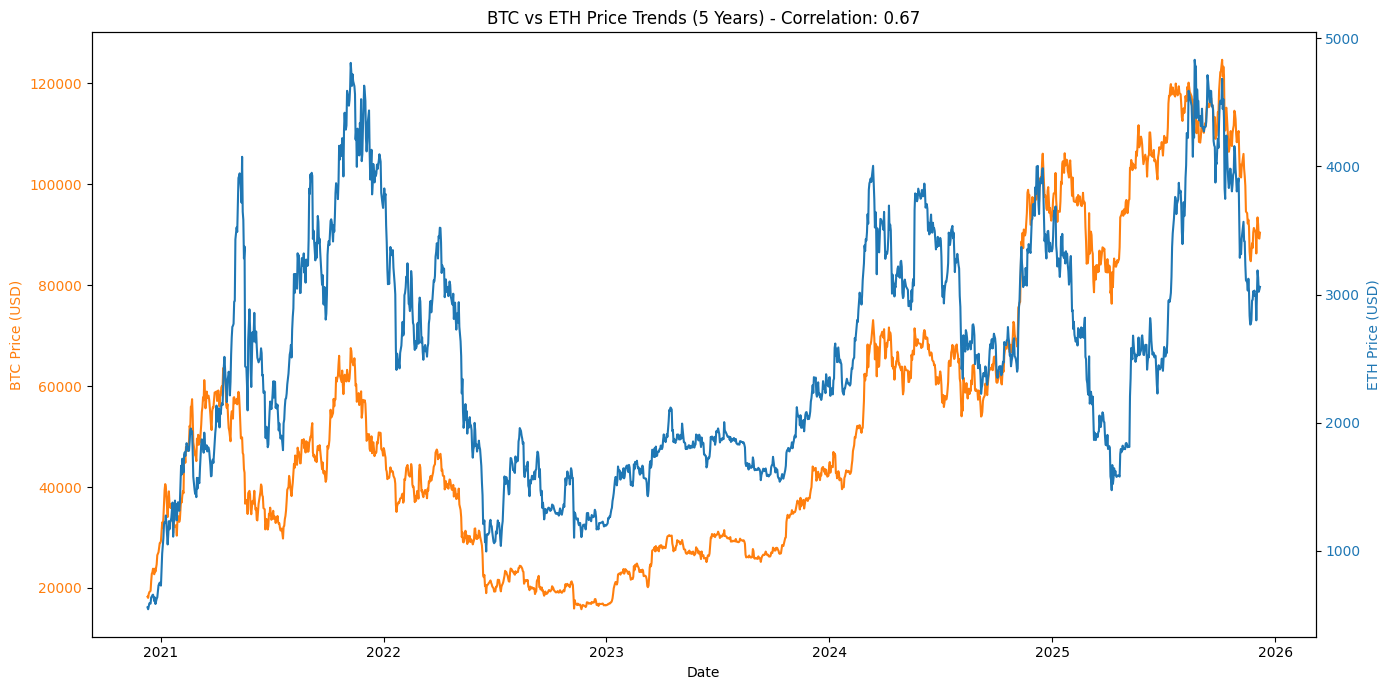

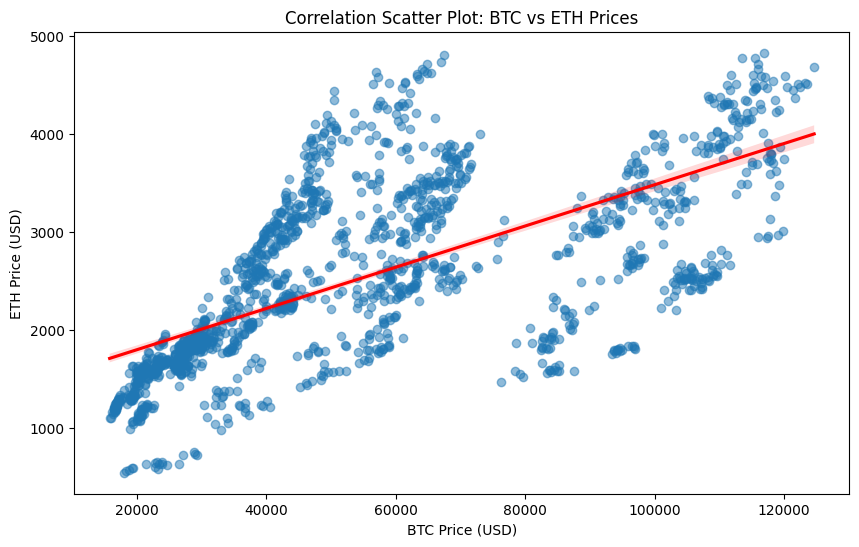

In [15]:
# Analysis and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Correlation
correlation = df_combined['Price_BTC'].corr(df_combined['Price_ETH'])
print(f"Correlation between BTC and ETH Prices: {correlation:.4f}")

# Visualization 1: Dual Axis Price Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color)
ax1.plot(df_combined['Date'], df_combined['Price_BTC'], color=color, label='BTC Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('ETH Price (USD)', color=color)
ax2.plot(df_combined['Date'], df_combined['Price_ETH'], color=color, label='ETH Price')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'BTC vs ETH Price Trends (5 Years) - Correlation: {correlation:.2f}')
fig.tight_layout()
plt.show()

# Visualization 2: Scatter Plot with Trendline
plt.figure(figsize=(10, 6))
sns.regplot(x='Price_BTC', y='Price_ETH', data=df_combined, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Correlation Scatter Plot: BTC vs ETH Prices')
plt.xlabel('BTC Price (USD)')
plt.ylabel('ETH Price (USD)')
plt.show()